In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import operator
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [0]:
data = pd.read_csv('Power-Networks-LCL.csv')

In [7]:
data.isnull().sum()

LCLid            0
stdorToU         0
DateTime         0
KWh              0
Acorn            0
Acorn_grouped    0
dtype: int64

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



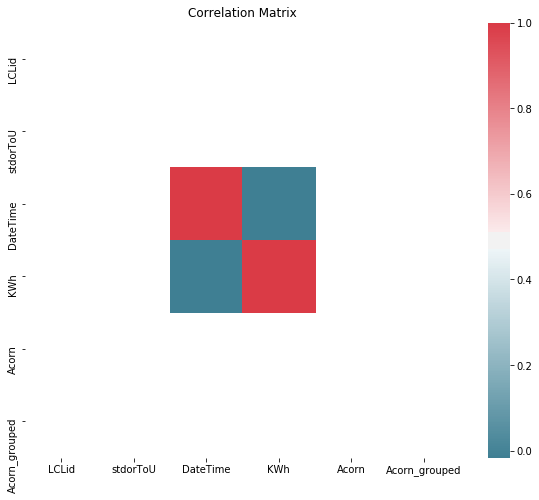

In [8]:
corrDF = data[(data['LCLid'] == 'MAC000021')]

for dt in corrDF.columns:
        if str(corrDF[dt].dtype) == 'object':
            corrDF[dt] = corrDF[dt].replace(to_replace=corrDF[dt].unique(), value=list(range(len(corrDF[dt].unique()))))
            
f, ax = plt.subplots(figsize=(10, 8))
ax.title.set_text('Correlation Matrix')
corr = corrDF.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [0]:
#Preparing DataFrame with datetime
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d  %H:%M:%S')
data = pd.read_csv('Power-Networks-LCL.csv', parse_dates=['DateTime'], index_col='DateTime',date_parser=dateparse)

In [0]:
#Filtering data since no correlation found between other features
dfTS = data.filter(['DateTime','KWh'], axis=1)

In [0]:
def preprocess(data):
    dictlist = []
    for i in range(2,37):
        if i < 10:
            LCLid = 'MAC00000' + str(i) 
        else:
            LCLid = 'MAC0000' + str(i)
        
        countDict = {}
        count = data[(data['LCLid'] == LCLid)].count()
        countDict['LCLid'] = LCLid
        countDict['count'] = str(count.LCLid)
        dictlist.append(countDict)
        
    #Sorting dictlist in descending order of count of sample provided
    sortedList=sorted(dictlist, key = lambda k:k['count'], reverse=True)
    
    #top 3 LCLid on the basis of sample count
    return sortedList[:3]      

In [0]:
top3LCLid = preprocess(data)

In [0]:
def forecastProphet(Hour_data):
  
  #Dividing data into train and test sets
  train_size = int(0.8 * len(Hour_data))
  X_train, X_test = Hour_data[:train_size].index, Hour_data[train_size:].index
  y_train, y_test = Hour_data[:train_size]["KWh"].values, Hour_data[train_size:]["KWh"].values
  
  #Preprocess data for Prophet
  train_df = pd.concat([pd.Series(X_train), pd.Series(y_train)], axis=1, keys=["ds", "y"])
  test_df = pd.concat([pd.Series(X_test), pd.Series([0]*len(y_test))], axis=1, keys=["ds", "y"])
  answer_df = pd.concat([pd.Series(X_test), pd.Series(y_test)], axis=1, keys=["ds", "y"])
  
  #Initialize model and train on training data
  model = Prophet()
  model.fit(train_df)
  
  #Predict using test data
  forecast = model.predict(test_df)
  
  #Plot forecast  
  model.plot(forecast)
  model.plot_components(forecast)
  
  #Cross validation and performance metrics
  df_cv = cross_validation(model, horizon="30 days")
  df_cv.head()
  
  df_p = performance_metrics(df_cv)
  print df_p

In [0]:
def getHourData():
  for i in range(0,3):
    LCLid = top3LCLid[i]['LCLid']
    dfTS  = data[(data['LCLid'] == LCLid)]
    dfTS  = dfTS.filter(['DateTime','KWh'], axis=1)
    
    #Resampling to get hourly data
    Hour_groups = dfTS.resample('H')
    Hour_data = Hour_groups.sum()

    #Send data for forecasting
    forecastProphet(Hour_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 36 forecasts with cutoffs between 2012-03-12 06:00:00 and 2013-08-19 06:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


             horizon       mse      rmse       mae      mape  coverage
0    3 days 00:00:00  0.093855  0.306358  0.193356  0.470765  0.900849
1    3 days 01:00:00  0.093758  0.306200  0.193391  0.471432  0.900849
2    3 days 02:00:00  0.093249  0.305367  0.193147  0.471708  0.900849
3    3 days 03:00:00  0.090243  0.300404  0.192286  0.472245  0.900849
4    3 days 04:00:00  0.088816  0.298020  0.191593  0.472216  0.900849
5    3 days 05:00:00  0.088733  0.297880  0.191998  0.472911  0.900463
6    3 days 06:00:00  0.087974  0.296604  0.191246  0.471672  0.901235
7    3 days 07:00:00  0.088677  0.297786  0.191930  0.471716  0.900849
8    3 days 08:00:00  0.088679  0.297790  0.192415  0.472818  0.900463
9    3 days 09:00:00  0.089825  0.299709  0.193188  0.472826  0.900077
10   3 days 10:00:00  0.092328  0.303855  0.194511  0.473506  0.898920
11   3 days 11:00:00  0.092927  0.304839  0.195117  0.474046  0.897762
12   3 days 12:00:00  0.094540  0.307473  0.196058  0.475714  0.895448
13   3

INFO:fbprophet:Making 36 forecasts with cutoffs between 2012-03-12 06:00:00 and 2013-08-19 06:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


             horizon       mse      rmse       mae      mape  coverage
0    3 days 00:00:00  0.039882  0.199706  0.127610  0.664709  0.924769
1    3 days 01:00:00  0.039943  0.199858  0.127722  0.663530  0.924383
2    3 days 02:00:00  0.040072  0.200179  0.128143  0.664004  0.923611
3    3 days 03:00:00  0.040026  0.200065  0.127891  0.662362  0.922840
4    3 days 04:00:00  0.040262  0.200655  0.128184  0.662977  0.922840
5    3 days 05:00:00  0.040199  0.200498  0.128090  0.662048  0.922068
6    3 days 06:00:00  0.040004  0.200011  0.128019  0.661883  0.922068
7    3 days 07:00:00  0.039703  0.199256  0.127824  0.662113  0.922068
8    3 days 08:00:00  0.040035  0.200087  0.128061  0.663116  0.922454
9    3 days 09:00:00  0.039593  0.198980  0.128031  0.664448  0.922840
10   3 days 10:00:00  0.039724  0.199310  0.128372  0.666915  0.922454
11   3 days 11:00:00  0.039037  0.197579  0.127737  0.666454  0.923225
12   3 days 12:00:00  0.040527  0.201313  0.128738  0.669445  0.922454
13   3

INFO:fbprophet:Making 36 forecasts with cutoffs between 2012-03-12 06:00:00 and 2013-08-19 06:00:00


             horizon       mse      rmse       mae      mape  coverage
0    3 days 00:00:00  0.138289  0.371872  0.256737  0.289736  0.872299
1    3 days 01:00:00  0.137964  0.371436  0.256469  0.289961  0.873457
2    3 days 02:00:00  0.136971  0.370096  0.255590  0.290089  0.874228
3    3 days 03:00:00  0.138960  0.372774  0.256234  0.290163  0.873071
4    3 days 04:00:00  0.142173  0.377059  0.257410  0.290997  0.871914
5    3 days 05:00:00  0.145491  0.381432  0.258727  0.292088  0.871528
6    3 days 06:00:00  0.149928  0.387205  0.260479  0.292762  0.870370
7    3 days 07:00:00  0.149741  0.386963  0.259743  0.293054  0.871142
8    3 days 08:00:00  0.147915  0.384597  0.258699  0.293540  0.871914
9    3 days 09:00:00  0.146576  0.382852  0.258146  0.294506  0.871914
10   3 days 10:00:00  0.145143  0.380977  0.256895  0.294701  0.873071
11   3 days 11:00:00  0.146078  0.382202  0.257463  0.295518  0.873071
12   3 days 12:00:00  0.146194  0.382353  0.257317  0.296051  0.873457
13   3

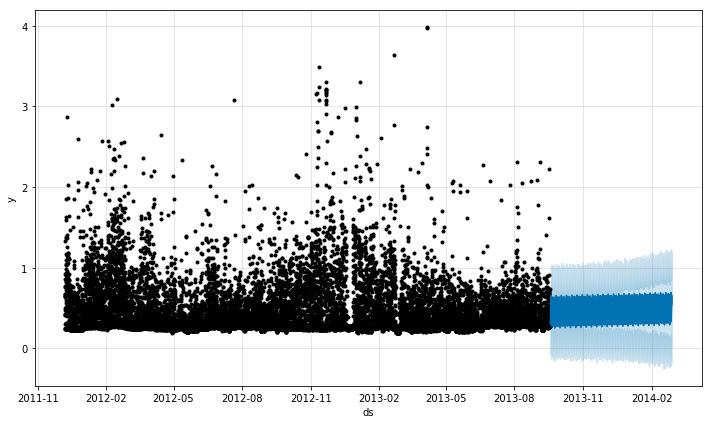

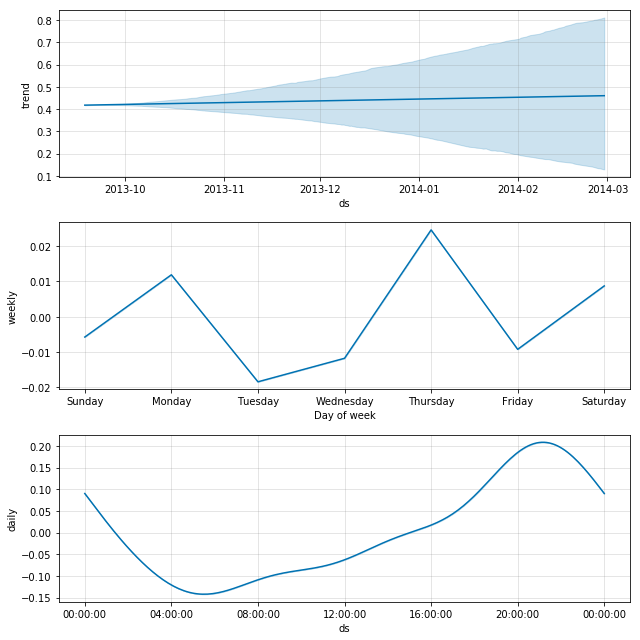

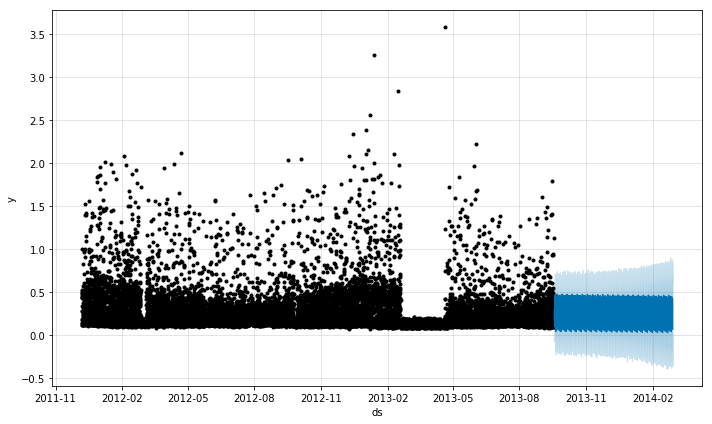

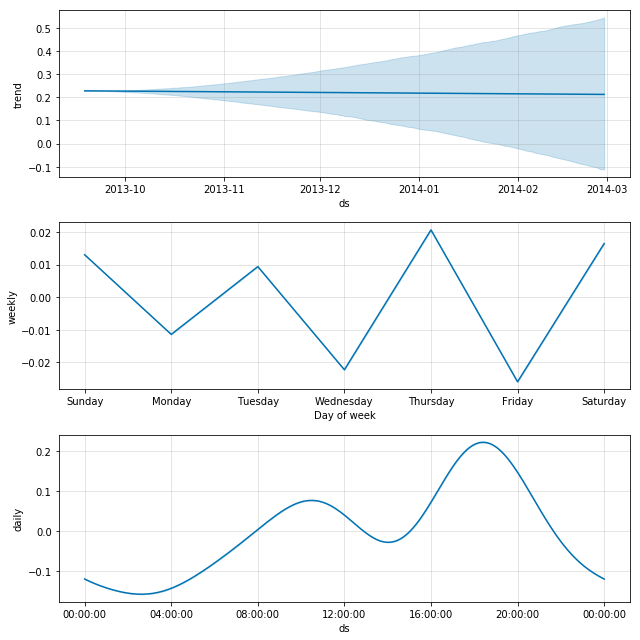

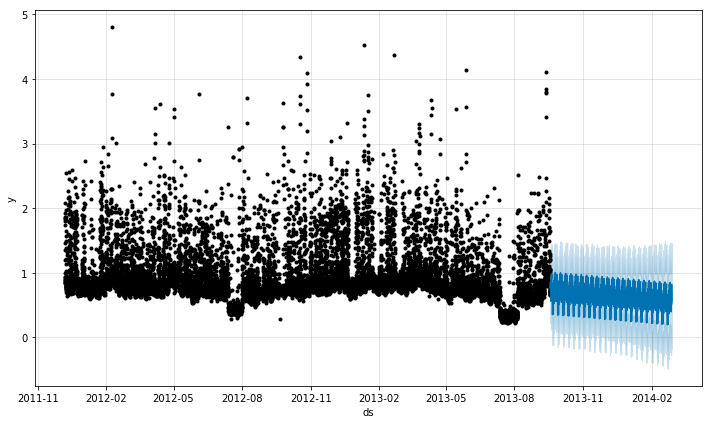

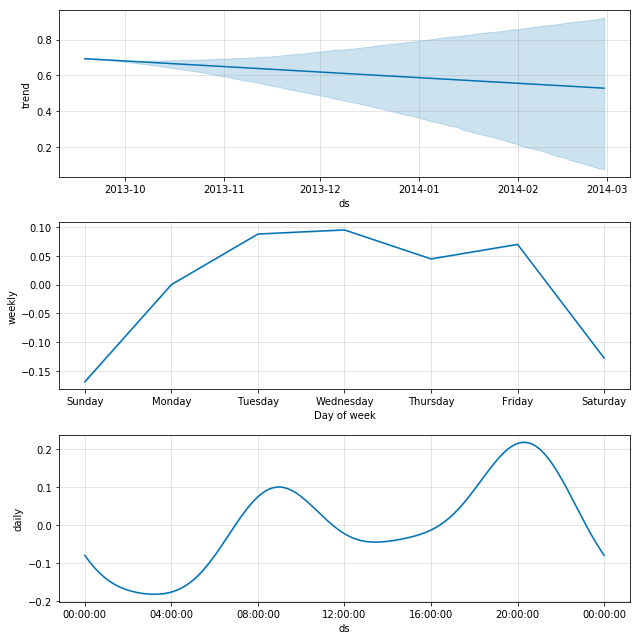

In [23]:
getHourData()